In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from datetime import datetime
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv("PS_data.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The major observation is that isFraud is heavily imbalanced (mean is very close to 0).

In [7]:
# check for missing data 
df.isnull().sum(axis=0) 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<AxesSubplot:>

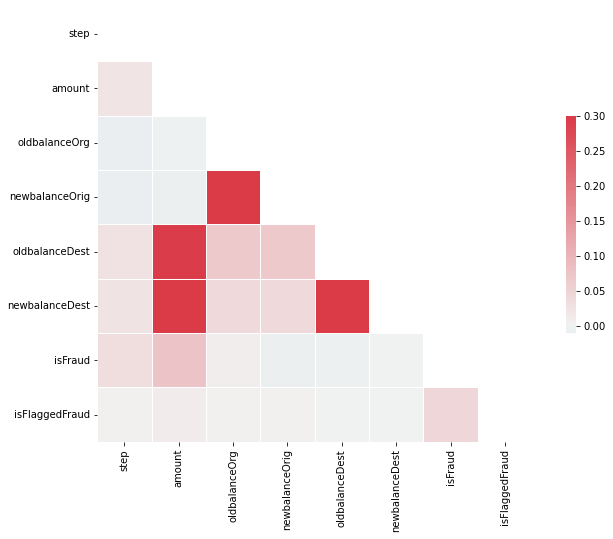

In [8]:
# explore feature correlations
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,8))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

From the heatmap, it doesn't seem like any of the features are too correlated with one another. Therefore, we will keep all of the features for now.

In [9]:
df.shape

(6362620, 11)

In [10]:
# do one-hot encoding for categorical variable
eda = df.join(pd.get_dummies(df['type']))

In [11]:
# add another column based on whether destination is merchant
eda['merchant'] = [1 if x[0]=="M" else 0 for x in eda['nameDest']]

In [12]:
# Get count of historical transactions per originating account
eda['numTransactHistOrig'] = eda[['nameOrig', 'step']].groupby(['nameOrig']).cumcount() + 1

# Get count of historical transactions per destination account
eda['numTransactHistDest'] = eda[['nameDest', 'step']].groupby(['nameDest']).cumcount() + 1

In [13]:
# distribution of total number of transactions (orig)
orig_transact_hist = eda[['nameOrig', 'numTransactHistOrig']].groupby(['numTransactHistOrig']).count()
orig_transact_hist = orig_transact_hist - orig_transact_hist.shift(-1).fillna(0)
orig_transact_hist

,nameOrig
numTransactHistOrig,
1,6344009.0
2,9283.0
3,15.0


In [14]:
# distribution of total number of transactions (dest)
dest_transact_hist = eda[['nameDest', 'numTransactHistDest']].groupby(['numTransactHistDest']).count()
dest_transact_hist = dest_transact_hist - dest_transact_hist.shift(-1).fillna(0)
dest_transact_hist

,nameDest
numTransactHistDest,
1,2262704.0
2,77054.0
3,57289.0
4,45115.0
5,36821.0
...,...
109,1.0
110,0.0
111,0.0


In [15]:
# Get information about change in balance of accounts
eda['balChangeOrig'] = eda.newbalanceOrig - eda.oldbalanceOrg
eda['balChangeDest'] = eda.newbalanceDest - eda.oldbalanceDest

# Binary encoding of receive money or spend money (1 receive, -1 spend, 0 no change)
eda['payTypeOrig'] = np.sign(eda.balChangeOrig)
eda['payTypeDest'] = np.sign(eda.balChangeDest)

# Get error in the balances
eda['errorBalOrig'] = eda.newbalanceOrig + eda.amount - eda.oldbalanceOrg
eda['errorBalDest'] = (eda.oldbalanceDest + eda.amount - eda.newbalanceDest)*(1 - eda.merchant)

# Binary encoding if net change in accts is 0 and payment was not done with merchant
eda['payNetZero'] = ((abs(eda.balChangeOrig + eda.balChangeDest) < 1e-5) | (eda.merchant == 1)).astype(int)

In [16]:
# Hour of day
eda['hour'] = eda.step % 24

In [17]:
# Get total number transactions per hour
transact_per_step = eda[['step', 'isFraud']].groupby('step').agg(['count',
                                                                 'sum']).reset_index()

# Get number of transactions in the previous hour
transact = pd.DataFrame({})
transact['step'] = transact_per_step['step']
transact['numTransact'] = transact_per_step.isFraud['count']
transact['numTransactLag1'] = transact_per_step.isFraud['count'].shift(1)
transact['numFraudLag1'] = transact_per_step.isFraud['sum'].shift(1)

eda = eda.merge(transact, on='step')

In [18]:
# If destination account has a previous transaction, get their previous transaction type and amount
eda['prevType'] = eda.groupby('nameDest')['type'].shift(1)
eda['prevAmount'] = eda.groupby('nameDest')['amount'].shift(1)
eda['timeStep'] = pd.to_datetime(datetime.today().date()) + pd.to_timedelta(eda['step'], unit='h')

In [20]:
# Get the average transaction amount the destination account had in the previous 24h
right_df = eda.groupby(['nameDest']).rolling('1D', min_periods=1,
                                             on='timeStep')['amount'].mean().groupby(["nameDest",
                                                                                      "timeStep"]).last().shift(1)
eda = eda.merge(right_df, on=['nameDest', 'timeStep'], how='left', suffixes=(None, "PrevDayAvg"))

In [11]:
total_transactions_per_hour = df.groupby('step')['amount'].count().reset_index()
total_transactions_per_hour = total_transactions_per_hour.rename(columns={'amount': 'numTransactLag1'})
total_transactions_per_hour['step'] = total_transactions_per_hour['step']+1 # lag step by 1

amt_transactions_per_hour = df.groupby('step')['amount'].sum().reset_index()
amt_transactions_per_hour = amt_transactions_per_hour.rename(columns={'amount': 'amtTransactLag1'})
amt_transactions_per_hour['step'] = amt_transactions_per_hour['step']+1 # lag step by 1

fraud_transactions_per_hour = df.groupby('step')['isFraud'].sum().reset_index()
fraud_transactions_per_hour = fraud_transactions_per_hour.rename(columns={'isFraud': 'numFraudLag1'})
fraud_transactions_per_hour['step'] = fraud_transactions_per_hour['step']+1 # lag step by 1

fraud_amt_transactions_per_hour = df[df['isFraud'] == 1].groupby('step')['amount'].sum().reset_index()
fraud_amt_transactions_per_hour = fraud_amt_transactions_per_hour.rename(columns={'amount': 'amtFraudLag1'})
fraud_amt_transactions_per_hour['step'] = fraud_amt_transactions_per_hour['step']+1 # lag step by 1

eda = eda.merge(
    total_transactions_per_hour,
    on = 'step',
    how='left',
)

eda = eda.merge(
    amt_transactions_per_hour,
    on = 'step',
    how='left',
)

eda = eda.merge(
    fraud_transactions_per_hour,
    on = 'step',
    how='left',
)

eda = eda.merge(
    fraud_amt_transactions_per_hour,
    on = 'step',
    how='left',
)

eda['amtFraudPctLag1'] = eda['amtFraudLag1'] / eda['amtTransactLag1']
eda['numFraudPctLag1'] = eda['numFraudLag1'] / eda['numTransactLag1']

In [12]:
# Lag the average over the last few hours to make the metrics less volatile
rolling_window = 5 # average over the last 5 time steps
pct_rolling = eda[['step','amtFraudPctLag1','numFraudPctLag1']].drop_duplicates()
pct_rolling['amtFraudPctAvgLag5'] = pct_rolling.rolling(rolling_window, min_periods=1)['amtFraudPctLag1'].mean()
pct_rolling['numFraudPctAvgLag5'] = pct_rolling.rolling(rolling_window, min_periods=1)['numFraudPctLag1'].mean()

eda = eda.merge(
    pct_rolling[['step','amtFraudPctAvgLag5','numFraudPctAvgLag5']],
    how='left',
    on='step'
)

In [ ]:
for transactType in eda['type'].unique():
    right_df = eda.groupby(['nameDest']).rolling('1D', min_periods=1,
                                                 on='timeStep')[transactType].sum().groupby(["nameDest",
                                                                                             "timeStep"]).last().shift(1)
    eda = eda.merge(right_df, on=['nameDest', 'timeStep'], how='left', suffixes=(None, "_count"))

In [21]:
# split into dependent and independent variables
y = eda['isFraud']
X = eda.loc[:, ~eda.columns.isin(['isFraud', 'isFlaggedFraud'])]

In [22]:
X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,...,numFraudLag1,prevType,prevAmount,timeStep,amountPrevDayAvg,PAYMENT_count,TRANSFER_count,CASH_OUT_count,DEBIT_count,CASH_IN_count
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,...,NaN,NaN,NaN,2022-11-08 01:00:00,3900.810000,1.0,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,...,NaN,NaN,NaN,2022-11-08 01:00:00,3981.890000,1.0,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,...,NaN,NaN,NaN,2022-11-08 01:00:00,230085.930000,0.0,0.0,1.0,0.0,3.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,...,NaN,NaN,NaN,2022-11-08 01:00:00,180708.610000,0.0,0.0,0.0,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,...,NaN,NaN,NaN,2022-11-08 01:00:00,15808.120000,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,...,14.0,CASH_IN,325100.59,2022-12-08 23:00:00,325100.590000,0.0,0.0,0.0,0.0,1.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,...,14.0,NaN,NaN,2022-12-08 23:00:00,361852.483333,0.0,1.0,1.0,0.0,1.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,...,14.0,CASH_OUT,68488.84,2022-12-08 23:00:00,68488.840000,0.0,0.0,1.0,0.0,0.0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,...,14.0,NaN,NaN,2022-12-08 23:00:00,54231.080000,0.0,0.0,1.0,0.0,0.0


In [23]:
X.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,...,numTransact,numTransactLag1,numFraudLag1,prevAmount,amountPrevDayAvg,PAYMENT_count,TRANSFER_count,CASH_OUT_count,DEBIT_count,CASH_IN_count
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,...,6.362620e+06,6.359912e+06,6.359912e+06,3.640258e+06,6.362619e+06,6.362619e+06,6.362619e+06,6.362619e+06,6.362619e+06,6.362619e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,...,2.946814e+04,2.788956e+04,1.147005e+01,2.706340e+05,1.791396e+05,3.381633e-01,2.346593e-01,9.264036e-01,1.728801e-02,5.321169e-01
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,...,1.139031e+04,1.249250e+04,5.159136e+00,7.596312e+05,4.826853e+05,4.731210e-01,6.577780e-01,1.588686e+00,1.376680e-01,1.045563e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.595600e+04,2.339100e+04,8.000000e+00,7.763573e+04,1.485942e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.088100e+04,2.992700e+04,1.000000e+01,1.612661e+05,1.041604e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,3.685600e+04,3.617600e+04,1.400000e+01,2.819599e+05,2.219594e+05,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,5.135200e+04,5.135200e+04,4.000000e+01,9.244552e+07,9.244552e+07,2.000000e+00,2.400000e+01,3.700000e+01,6.000000e+00,4.100000e+01


## Visualisations

Text(0, 0.5, 'Number of Accounts (logscale)')

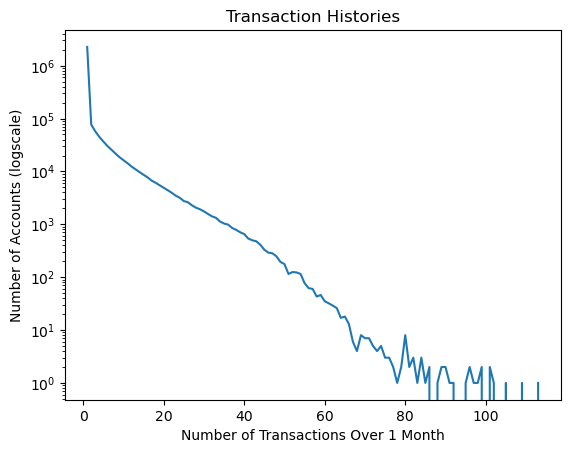

In [25]:
dest_transact_hist.plot(logy=True, legend=False)
plt.title("Transaction Histories")
plt.xlabel("Number of Transactions Over 1 Month")
plt.ylabel("Number of Accounts (logscale)")

[(0.0, 1000000.0)]

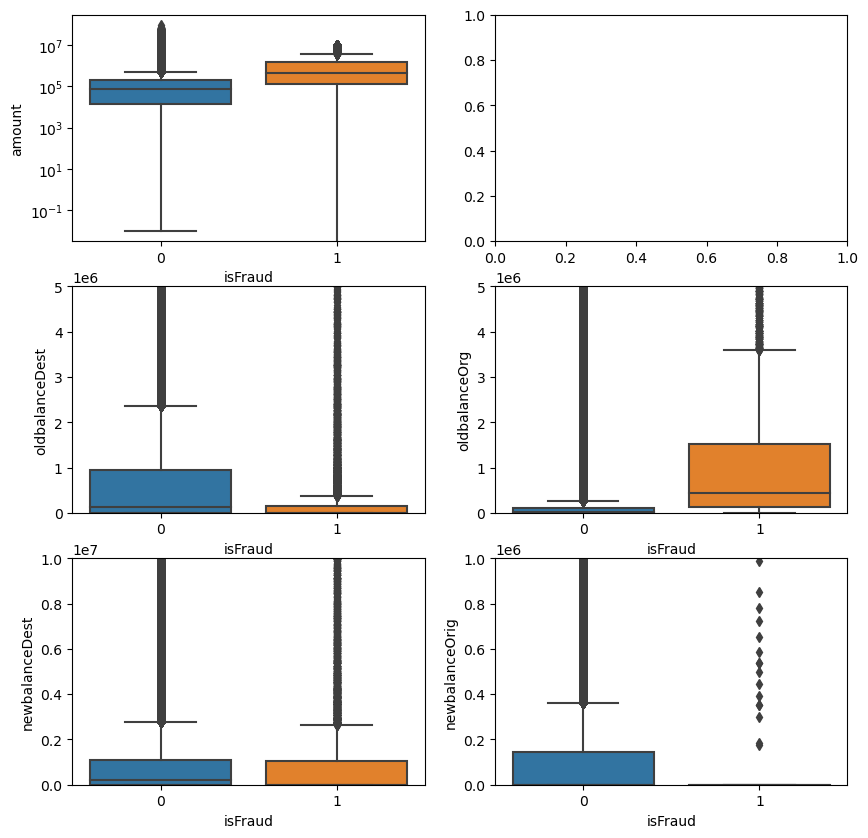

In [26]:
# Visualize box plots for some balance and amount features
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.boxplot(x = 'isFraud', y = 'amount', data = df, ax=axs[0][0])
axs[0][0].set_yscale('log')

sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = df, ax=axs[1][0])
axs[1][0].set(ylim=(0, 5e6))

sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data = df, ax=axs[1][1])
axs[1][1].set(ylim=(0, 5e6))

sns.boxplot(x = 'isFraud', y = 'newbalanceDest', data = df, ax=axs[2][0])
axs[2][0].set(ylim=(0, 1e7))

sns.boxplot(x = 'isFraud', y = 'newbalanceOrig', data = df, ax=axs[2][1])
axs[2][1].set(ylim=(0, 1e6))

<AxesSubplot:xlabel='type', ylabel='isFraud'>

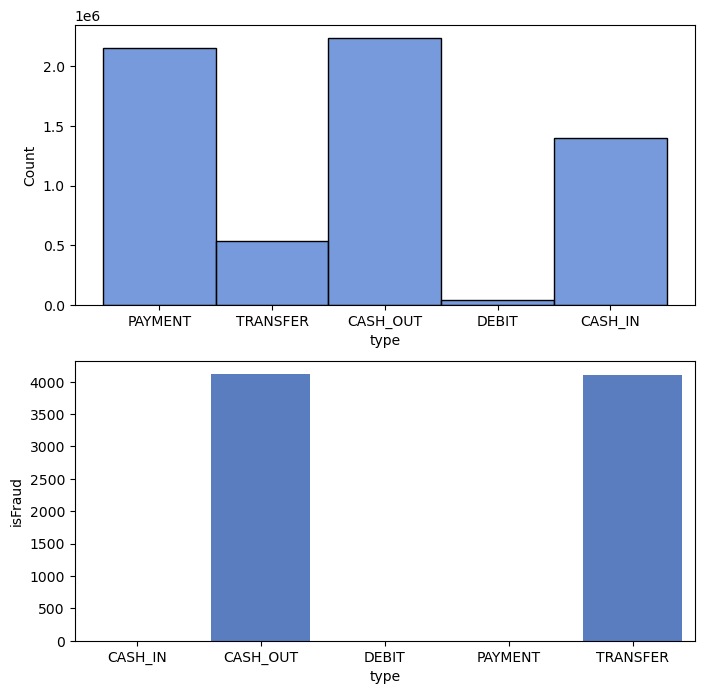

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
sns.histplot(df.type, ax = axs[0], color='#4878D0')
sns.barplot(df[['type', 'isFraud']].groupby('type').sum().reset_index(),
            x='type', y='isFraud', ax = axs[1], color='#4878D0')

Text(0.5, 0, 'error in Origination')

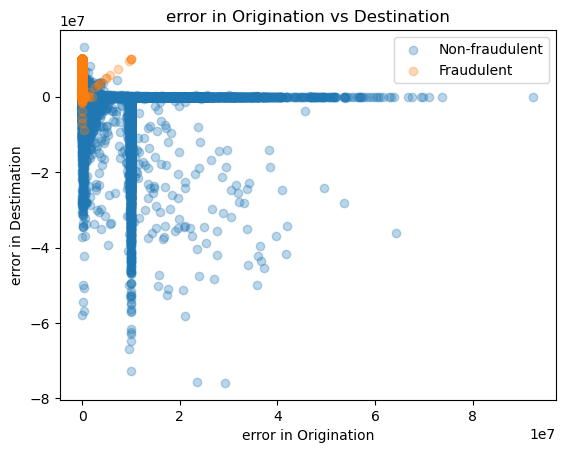

In [28]:
plt.scatter(x = X.errorBalOrig * (1-y), y = X.errorBalDest * (1-y),
            alpha=0.3, label='Non-fraudulent')
plt.scatter(x = X.errorBalOrig * y, y = X.errorBalDest * y,
            alpha=0.3, label='Fraudulent')
plt.legend()
plt.title('error in Origination vs Destination')
plt.ylabel('error in Destimation')
plt.xlabel('error in Origination')

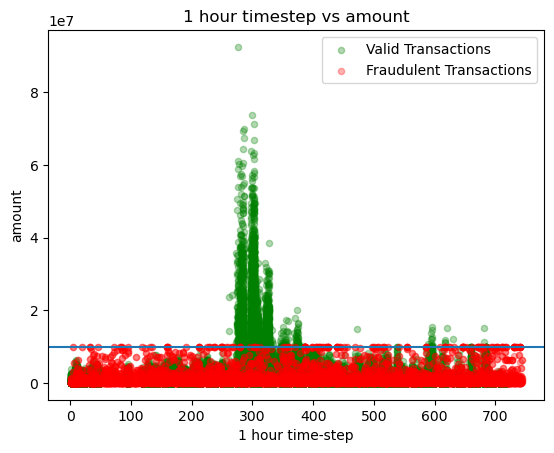

Proportion of transactions where the amount moved is greater than 10 million:  0.00038396132410862193


In [29]:
# plotting overlayed step vs amount scatter plots

alpha = 0.3
fig,ax = plt.subplots()
X.loc[y==0].plot.scatter(x="step",y="amount",color="green",alpha=alpha,ax=ax,label="Valid Transactions")
X.loc[y==1].plot.scatter(x="step",y="amount",color="red",alpha=alpha,ax=ax, label="Fraudulent Transactions")

plt.title("1 hour timestep vs amount")
plt.xlabel("1 hour time-step")
plt.ylabel("amount")
plt.legend(loc="upper right")

# plotting a horizontal line to show where valid transactions behave very differently from fraud transactions

plt.axhline(y=10000000)
plt.show()


print("Proportion of transactions where the amount moved is greater than 10 million: ", \
      len(eda[eda.amount > 10000000])/len(eda))

array([<AxesSubplot:ylabel='fraud'>, <AxesSubplot:ylabel='merchant'>],
      dtype=object)

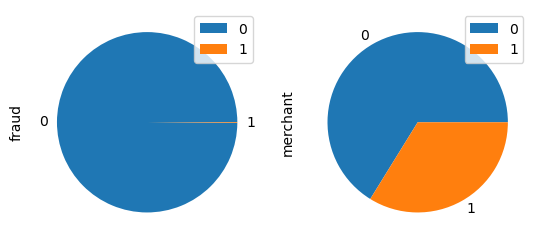

In [30]:
pie_df = pd.DataFrame({'fraud': [y.count()-y.sum(), y.sum()],
                       'merchant': [X.merchant.count() - X.merchant.sum(), X.merchant.sum()]})

# Checking for balance in target
pie_df.plot(kind='pie', subplots=True)

## INSERT MORE FEATURE ENGINEERING HERE.
Particularly, it would be useful to look at the nameOrig and nameDest and perhaps engineer features based on their previous transactions. The cells below will only run once all of our columns are numerical.

In [31]:
# # use an oversampling technique to correct imbalanced data
# smote = SMOTE()
# X_SMOTE, y_SMOTE = smote.fit_resample(X,y)
# print(sorted(Counter(y_SMOTE).items()))
# X_SMOTE = pd.DataFrame(X_SMOTE)
# X_SMOTE.columns = X.columns
# y_SMOTE = pd.DataFrame(y_SMOTE)

## Data Preprocessing

In [32]:
# remove one-hot encoded column
X.drop(['type'], axis=1, inplace=True)

/var/folders/l6/wrqrkr6x7p9gwwx_nfkt9qgr0000gn/T/ipykernel_83647/4111650411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['type'], axis=1, inplace=True)


In [36]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE,test_size=0.30)

In [ ]:
# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)